In [1]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [2]:
DATASET_PATH = "/Users/manojmohan/projects/datasets"
CHECKPOINT_PATH = "/Users/manojmohan/projects/checkpoints/tutorial3"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")

Using device: cpu


In [3]:
import urllib.request
from urllib.error import HTTPError

base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]


for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong")

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [6]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

ReLU (advantage over Tanh & Sigmoid) - strong, stable gradient for a large range of values
Variants:
  - LeakyReLU - replaces zero settings in the negative part with a smaller slope
  - ELU - replaces negative part with exponential decay
  - Swish - smooth and non-monotonic(contains a change of sign in the gradient)

In [57]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

class GELU(ActivationFunction):
    def forward(self, x):
        return F.gelu(x)

class ReLU6(ActivationFunction):
    def forward(self, x):
        return nn.ReLU6()(x)

In [58]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
    "gelu": GELU,
    "relu6": ReLU6
}

### Visualization of activation & gradient

In [59]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward() #summing results in an equal gradient flow to each element in x
    return x.grad

def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.legend()
    ax.set_ylim(-1.5, x.max())
    ax.set_title(act_fn.config["name"])

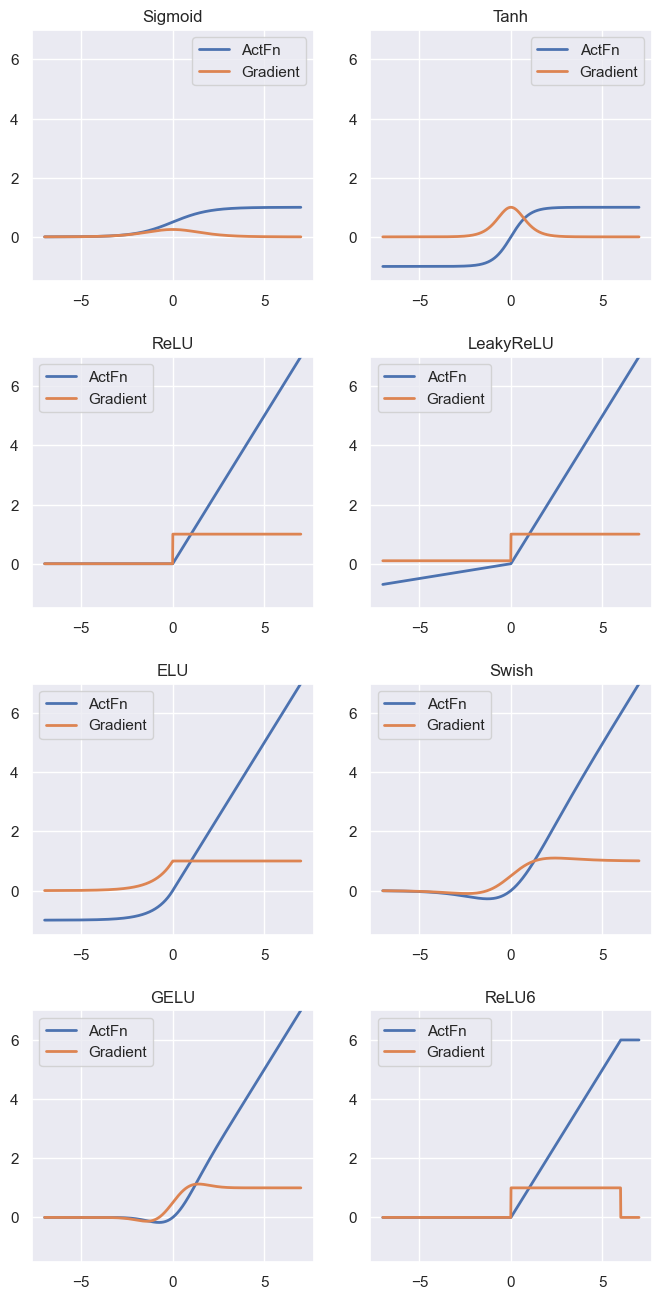

In [61]:
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-7, 7, 1000)

rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, 2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

([<matplotlib.lines.Line2D at 0x29c6913c0>],
 [<matplotlib.lines.Line2D at 0x29c921ba0>])

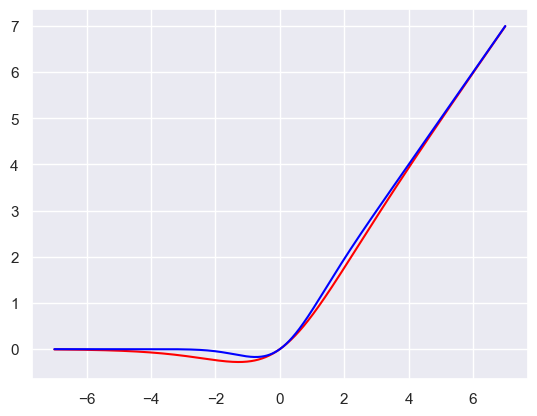

In [68]:
plt.plot(x, Swish()(x), color="red"), plt.plot(x, GELU()(x), color="blue")

([<matplotlib.lines.Line2D at 0x2920f3cd0>],
 [<matplotlib.lines.Line2D at 0x29c761ea0>])

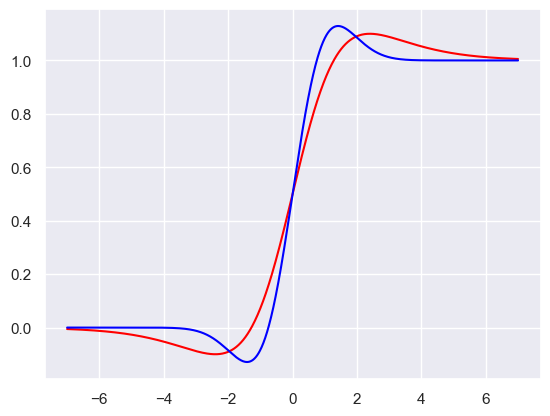

In [67]:
plt.plot(x, get_grads(Swish(), x), color="red"), plt.plot(x, get_grads(GELU(), x), color="blue")

#### GELU has a steeper slope at x = 0 than Swish

### Analysing the effect of activation functions

In [69]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        out = self.layers(x)
        return out

In [70]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

#### Train using FashionMNIST

In [71]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|████████████| 26421880/26421880 [00:07<00:00, 3756281.13it/s]


Extracting /Users/manojmohan/projects/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/manojmohan/projects/datasets/FashionMNIST/raw



100%|███████████████████| 29515/29515 [00:00<00:00, 178733.43it/s]


Extracting /Users/manojmohan/projects/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/manojmohan/projects/datasets/FashionMNIST/raw



100%|██████████████| 4422102/4422102 [00:01<00:00, 3008379.95it/s]


Extracting /Users/manojmohan/projects/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/manojmohan/projects/datasets/FashionMNIST/raw



100%|███████████████████| 5148/5148 [00:00<00:00, 12898612.30it/s]

Extracting /Users/manojmohan/projects/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/manojmohan/projects/datasets/FashionMNIST/raw



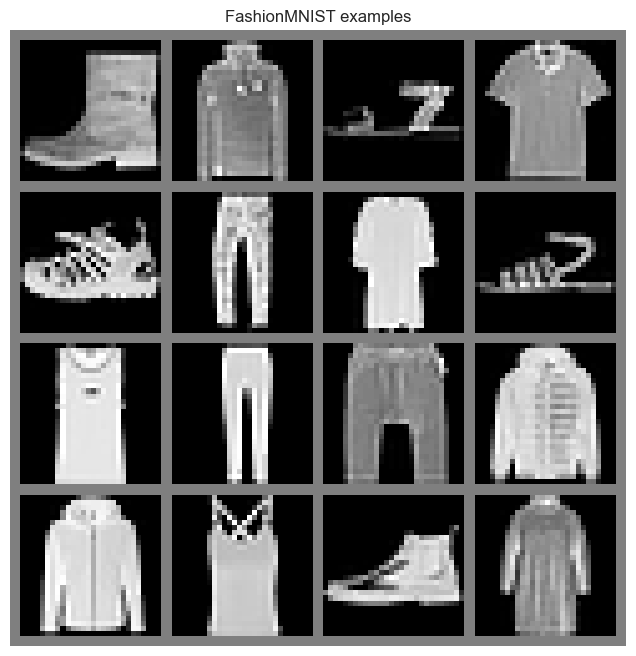

In [72]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

#### Visualize gradient flow after initialization

In [77]:
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # visualize only weights, exclude bias
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()
    

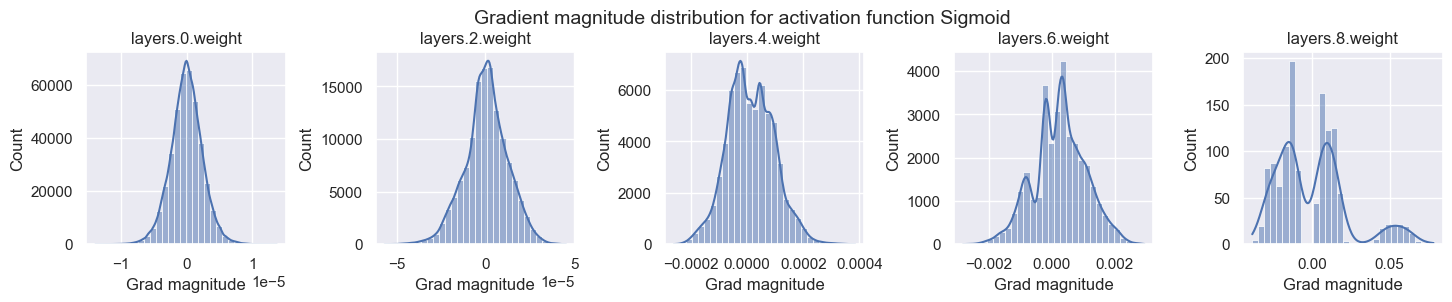

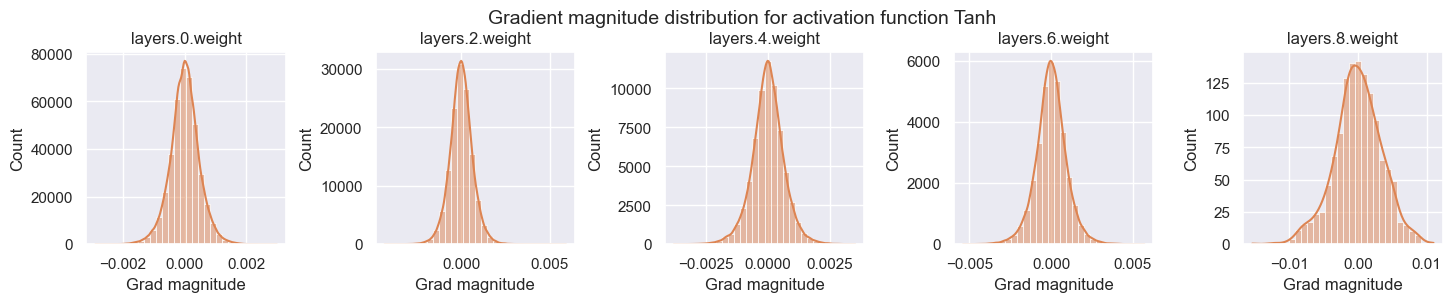

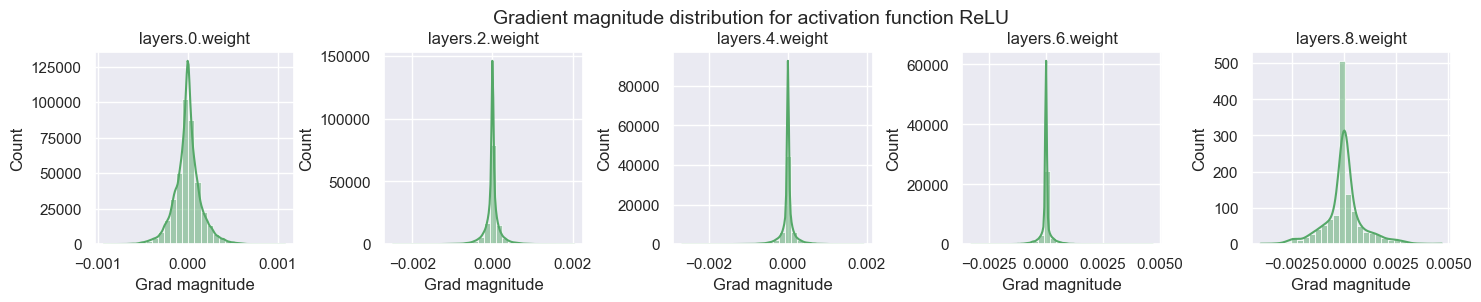

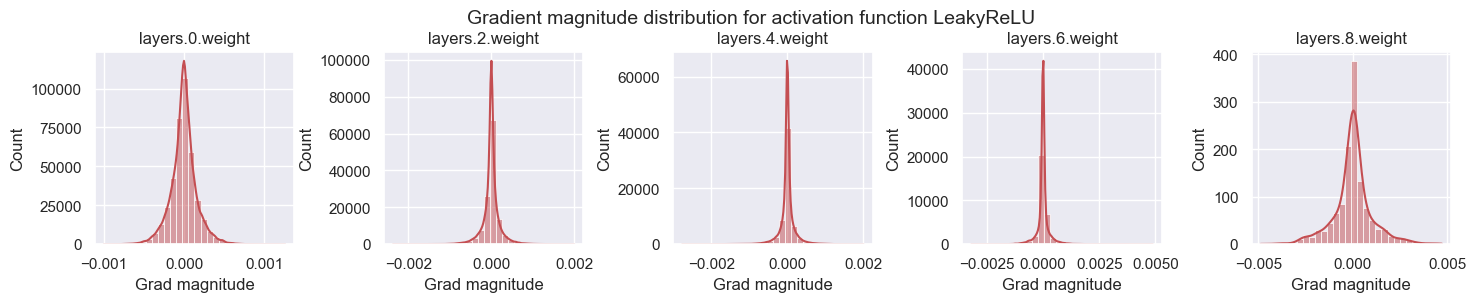

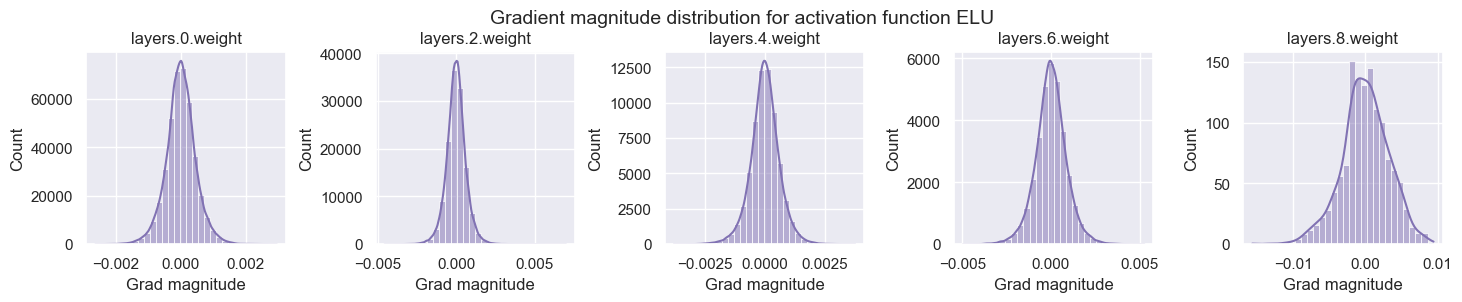

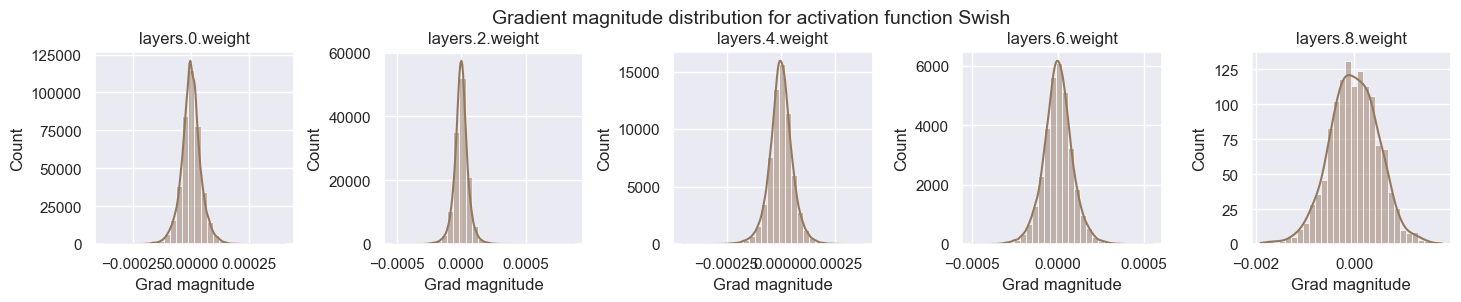

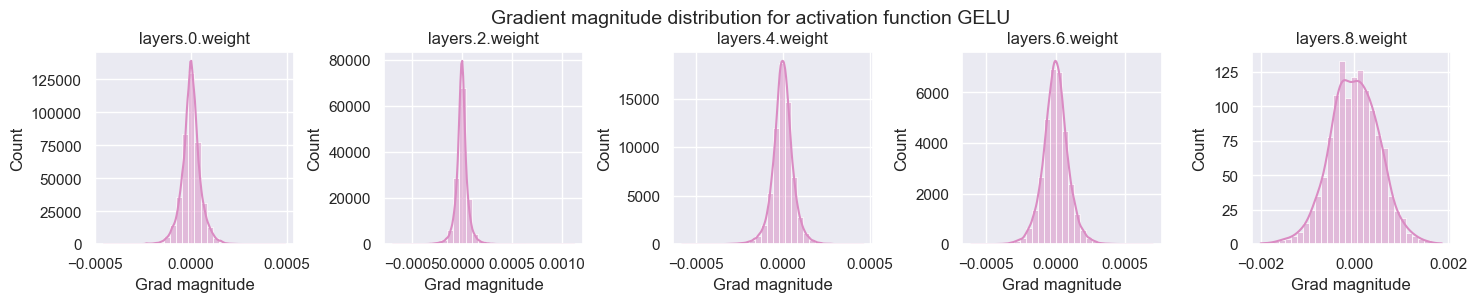

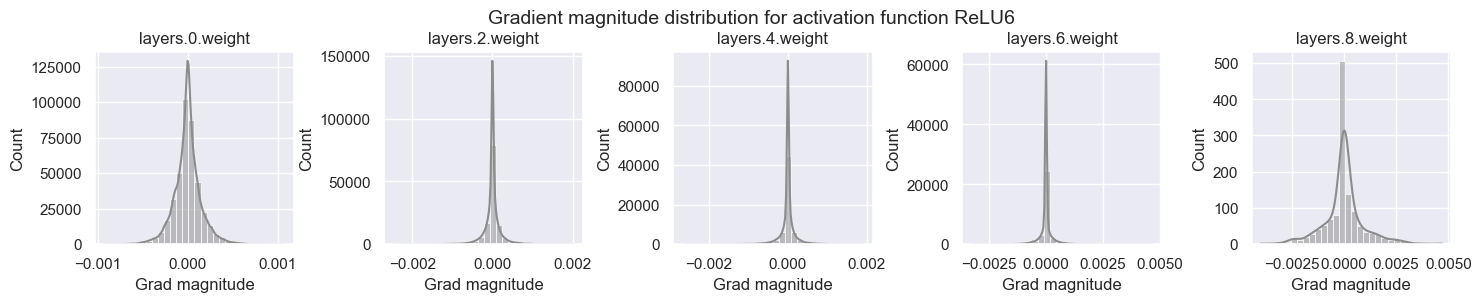

In [78]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

In [80]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.59% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.92% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.27% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.73% ==============

Training BaseNetwork with gelu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 31.63%, Validation accuracy: 60.14%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 73.22%, Validation accuracy: 79.13%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 81.49%, Validation accuracy: 83.68%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 83.91%, Validation accuracy: 83.93%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 84.94%, Validation accuracy: 83.53%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 85.77%, Validation accuracy: 85.54%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.49%, Validation accuracy: 86.10%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.94%, Validation accuracy: 85.81%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.18%, Validation accuracy: 85.25%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.65%, Validation accuracy: 87.06%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 88.16%, Validation accuracy: 86.93%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.45%, Validation accuracy: 87.37%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.70%, Validation accuracy: 88.20%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.96%, Validation accuracy: 87.61%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 89.38%, Validation accuracy: 86.74%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 89.65%, Validation accuracy: 88.43%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 90.02%, Validation accuracy: 88.06%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 90.05%, Validation accuracy: 88.57%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 90.26%, Validation accuracy: 88.27%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 90.50%, Validation accuracy: 88.46%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.83%, Validation accuracy: 88.46%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 91.02%, Validation accuracy: 88.59%
	   (New best performance, saving model...)


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 91.28%, Validation accuracy: 88.09%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 91.37%, Validation accuracy: 88.99%
	   (New best performance, saving model...)


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 91.56%, Validation accuracy: 88.72%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 91.75%, Validation accuracy: 88.56%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 91.89%, Validation accuracy: 89.08%
	   (New best performance, saving model...)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 92.17%, Validation accuracy: 89.19%
	   (New best performance, saving model...)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 92.23%, Validation accuracy: 88.89%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 92.54%, Validation accuracy: 89.41%
	   (New best performance, saving model...)


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 92.77%, Validation accuracy: 88.60%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 93.03%, Validation accuracy: 89.61%
	   (New best performance, saving model...)


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 92.95%, Validation accuracy: 89.04%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 93.16%, Validation accuracy: 89.42%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 93.49%, Validation accuracy: 89.35%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 93.63%, Validation accuracy: 89.40%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 93.73%, Validation accuracy: 89.05%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 93.76%, Validation accuracy: 89.33%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 93.98%, Validation accuracy: 88.86%
Early stopping due to no improvement over the last 7 epochs


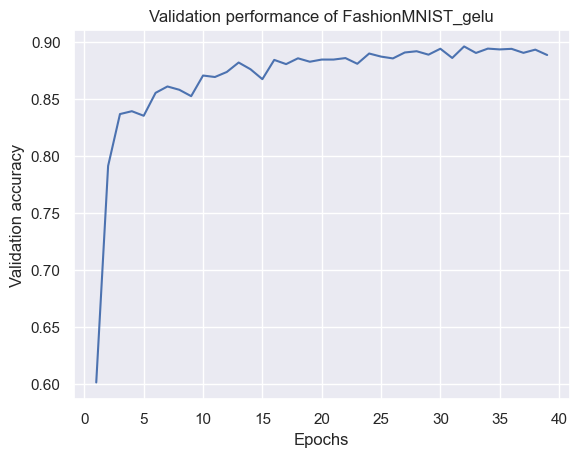

============= Test accuracy: 88.51% ==============

Training BaseNetwork with relu6 activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 50.19%, Validation accuracy: 73.41%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 78.93%, Validation accuracy: 80.74%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.17%, Validation accuracy: 84.16%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.89%, Validation accuracy: 84.97%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.74%, Validation accuracy: 85.26%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.79%, Validation accuracy: 86.77%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.54%, Validation accuracy: 87.28%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 88.31%, Validation accuracy: 87.24%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.49%, Validation accuracy: 86.41%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.09%, Validation accuracy: 87.26%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.55%, Validation accuracy: 87.93%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.80%, Validation accuracy: 87.43%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.12%, Validation accuracy: 88.96%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.47%, Validation accuracy: 87.44%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.89%, Validation accuracy: 87.93%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.41%, Validation accuracy: 88.13%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.31%, Validation accuracy: 89.41%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.54%, Validation accuracy: 88.91%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 91.99%, Validation accuracy: 88.73%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 92.19%, Validation accuracy: 89.22%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.63%, Validation accuracy: 88.86%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.99%, Validation accuracy: 89.41%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 93.12%, Validation accuracy: 89.06%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 93.28%, Validation accuracy: 89.19%
Early stopping due to no improvement over the last 7 epochs


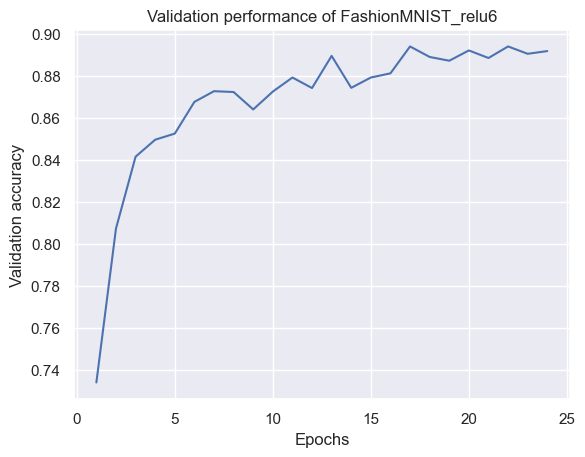

============= Test accuracy: 88.48% ==============



In [81]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

#### Visualize the activation distribution

In [83]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

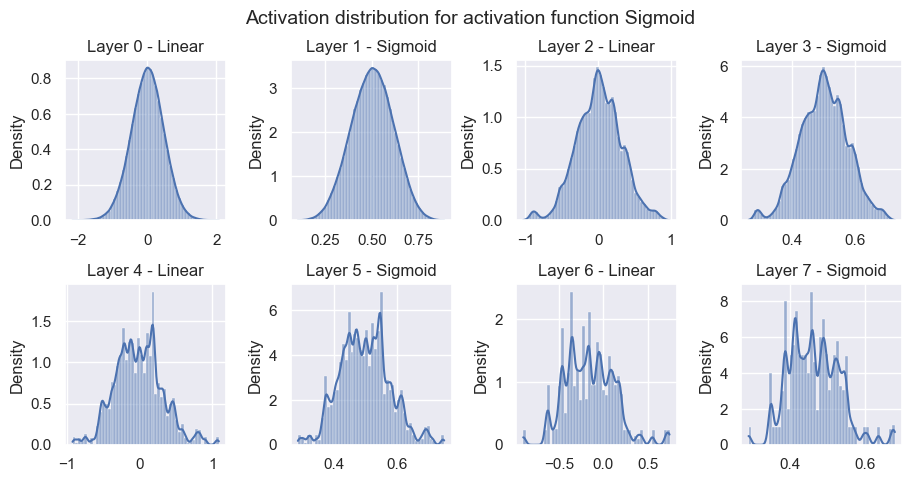

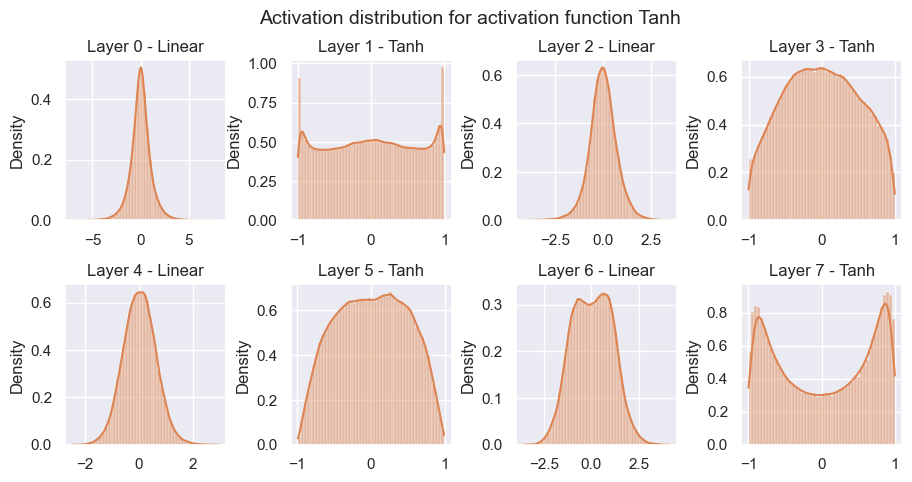

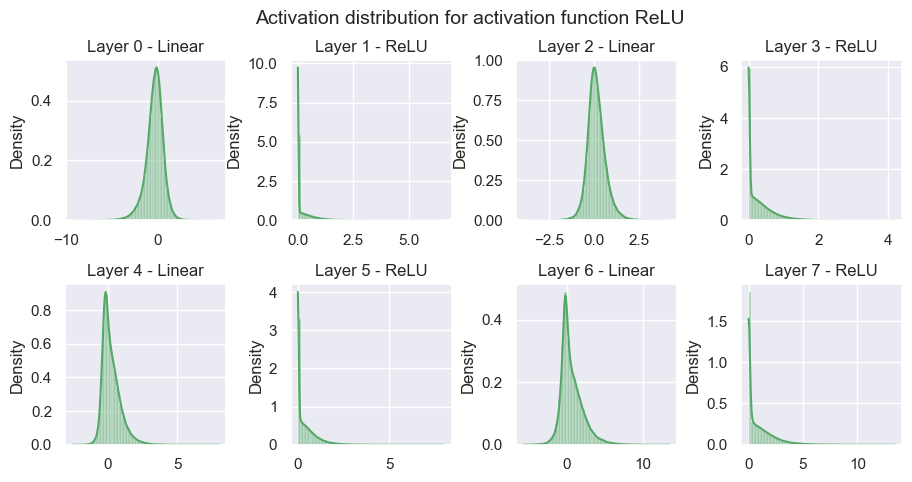

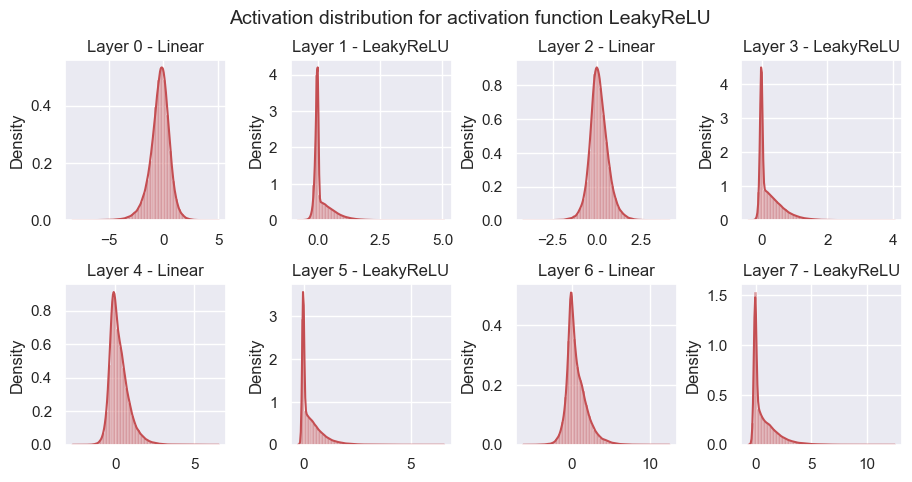

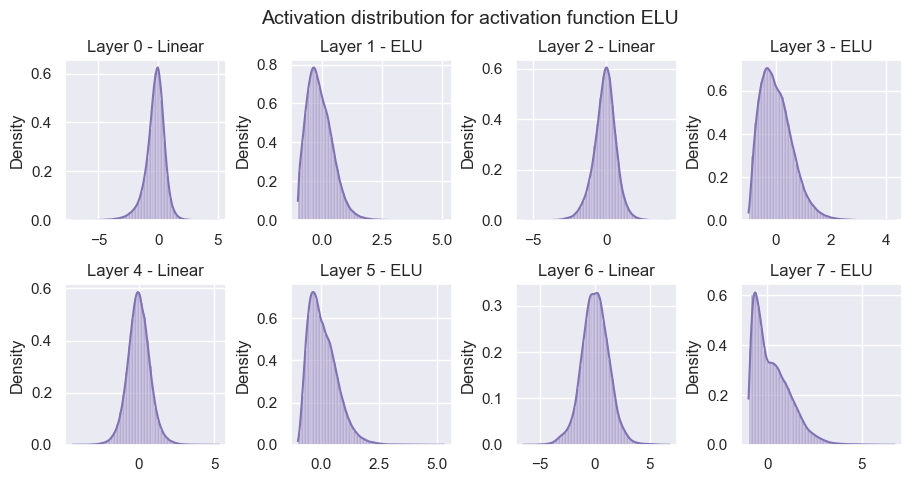

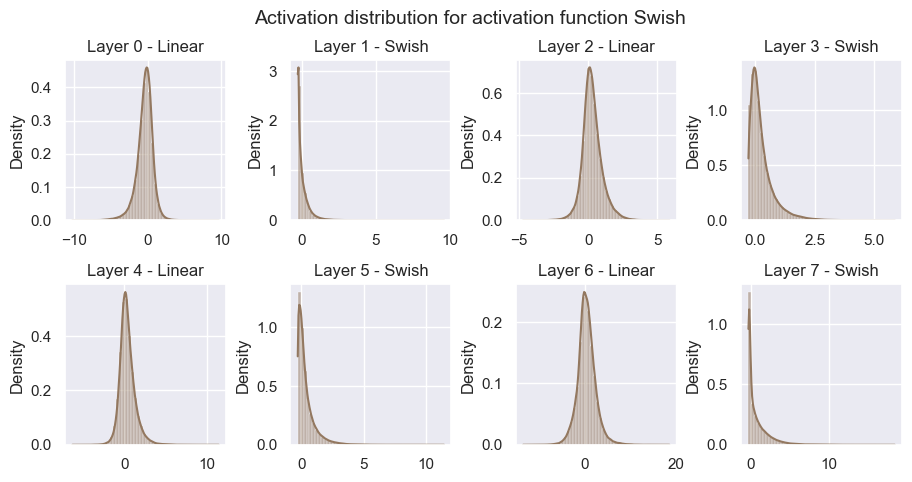

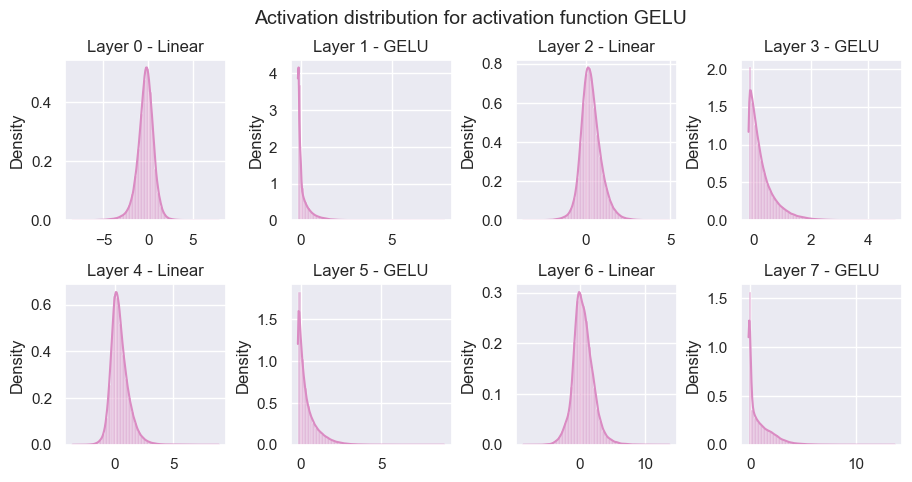

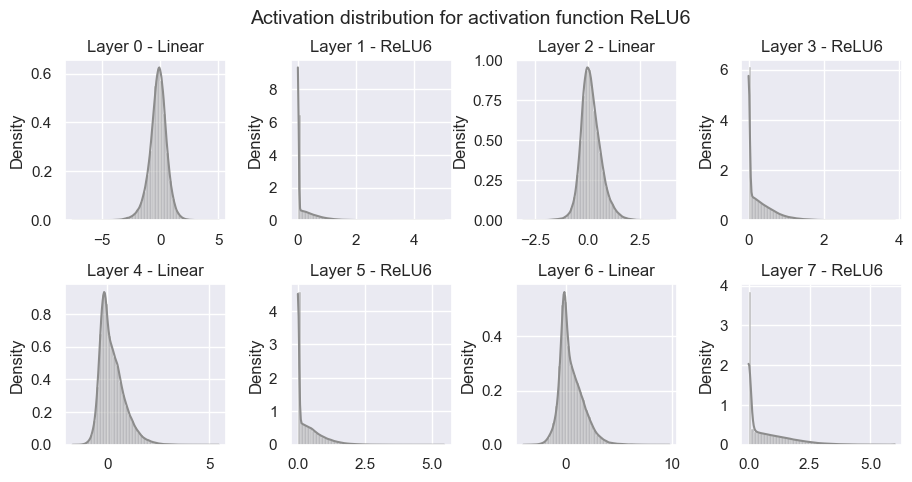

In [84]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

#### Finding dead neurons

In [87]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork
    print(neurons_dead[0].shape)

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [94]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

torch.Size([512])


  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [90]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

torch.Size([512])


  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 3]
In percentage: 0.00%, 0.00%, 0.00%, 2.34%


#### Deeper network has more dead neurons with ReLU, use other activations like Swish

In [91]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

torch.Size([256])


  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
